# Import Packages

In [311]:
# import packages

import collections
import math
import matplotlib.pyplot as pp
import numpy as np
import tslearn.utils
import pandas as pd
import yfinance as yf
from collections import deque
from copy  import deepcopy
from datetime import datetime, timedelta
from fastdtw import fastdtw
import glob
from itertools import islice
from IPython.display import display
from math import sqrt
from matplotlib.pyplot import figure
from pandas import DataFrame
from pandas_datareader import data as pdr
from pytrends.request import TrendReq
from scipy.stats import ttest_1samp
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_1samp
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series
import yfinance as yf

%matplotlib inline

# Data Pre-processing

## Config View

In [312]:
# set maximum viewing window (personal preference)
pd.set_option('display.max_rows', 500)

# Sentiment Analysis - Google

## Configurations

### Lists of Keywords:
- **Recession**
- **Finanial Crisis**
- **Market Crash**
- **Economy**

**This keywords are tested and handpicked**

These terms are also tested but not included due to either too general or too specfic.
- Disaster
- Crisis
- Covid
- Pandemic

After some experiment, it was decided to leave the list simple and general. Since a worldwide crisis can come in many forms with new terms are often developed to describe them, for example 'Covid'. This made targeting it very difficult if not impossible. Additionally, a post-crisis environment can be very subjective and is not very well defined. This method uses the 2008 GFC as a benchmark. Terms like 'death', depression', 'world war', etc are excluded due to wide usage causing unexpected results. Terms associated with natural disasters often led to results that are too 'regional' hence also excluded.

In [313]:
# Configure Keywords
keywords = ['Recession', 'Financial Crisis', 'Market Crash', 'Economy']

# NOTE: Search terms reference Irresberger et al. (2015) [4 keywords]; Anastasious & Drakos (2021) [p119-p120 in particular] --> irrational choices

# Tempo Array (apply this when search terms <= 5)
# keyword = []

In [314]:
# Configure search period
start_end = '2007-02-26 2021-03-20'

In [315]:
# Configure other parameters
timeframe = start_end
cat = '16' # News = 16 (Google ID)
geo = 'US' # US for America
gprop = '' # Google property filter

In [316]:
# Config package (Needed for the package to run properly)
pytrends = TrendReq(hl = 'en-US')

## Define Functions

In [317]:
# Define Search Function
def search_trends():
    pytrends.build_payload(keywords, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    return data

In [318]:
# Iteration Search for when keywords >= 5
# for kw in keywords:
#     keyword.append(kw)
#     search_trends()
#     keywords.pop()

In [319]:
# Define Function to check critical values, this function only prints informative values
def check_crisis(data):
    for kw in keywords:
        mean = round(data[kw].mean(), 2)
        avg_12 = round(data[kw][-12:].mean(),2)
        avg_L5 = round(data[kw][-60:].mean(),2)
        avg2008 = round(data[data.index.year == 2008][kw].mean(), 2)
        print(kw + ' all time mean: ' + str(mean))
        print(kw + ' last year mean: ' + str(avg_12))
        print(kw + ' last 5 year mean: ' + str(avg_L5))
        print(kw + ' 2008 mean: ' + str(avg2008))

In [320]:
# Define Function for FEARS Index Part 1
def fearsindex_df(data):
    pp.figure(figsize=(20,10))
    data1 = data.copy(deep=True)
    data1['t'] = np.arange(start = 1, stop = len(data1) + 1) ### Step2 prep. set time-series index t
    mon_dum = pd.get_dummies(data1.index.month, prefix = 'Month').iloc[:, 1:] ### Step2 prep. Get monthly Dummies 
    data1 = pd.concat([data1, mon_dum.set_index(data1.index)], axis = 1) ### Step2 prep. Put Dummies into Table
    for kw in keywords:
        col_name1 = kw + '_deltaGSVI'
        col_name2 = kw + '_deltaGSVI_residual'
        col_name3 = kw + '_Adjusted_deltaGSVI'
        ### Compute the FEARS Index
        data1[kw] = winsorize(data1[kw], limits=[0.025, 0.025]) ### Step1. winsorize 95-percent
        data1[col_name1] = np.log(data1[kw]) - np.log(data1[kw].shift(1)) ### Step2a. Compute deltaAGSVI(i,t) - weekly log change
        data1[col_name1] = data1[col_name1].fillna(0)
        fit = ols('data1[col_name1] ~ t + C(Month_2) + C(Month_3) + C(Month_4) + C(Month_5) + C(Month_6) + C(Month_7) + C(Month_8) + C(Month_9) + C(Month_10) + C(Month_11) + C(Month_12)', data = data1).fit() ### Step2b. linear regression on monthly dummies
        data1[col_name2] = fit.resid ### Step2c. retrive the residual
        ### Step3. scale by standard deviation
        ### Attribute: https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
        ### Author: Jason Brownlee
        temp = data1[col_name2].values.reshape(-1,1)
        scaler = StandardScaler()
        scaler = scaler.fit(temp)
        print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
        data1[col_name3] = scaler.transform(temp)
        ### Plot some graph for visualisation
        fig, ax1 = pp.subplots()
        color = 'tab:blue'
        ax1.set_ylabel('Google Search Index', color = 'blue')
        ax1.plot(data1.index.values, data1[kw]) 
        ax1.tick_params(axis ='y', labelcolor = 'blue') 
        ax2 = ax1.twinx() 
        color = 'tab:red'
        ax2.set_ylabel('Adjusted Delta GSVI', color = 'red') 
        ax2.plot(data1.index.values, data1[col_name3], color = 'red') 
        ax2.tick_params(axis ='y', labelcolor = 'red') 
        pp.title(kw + ' GSVI and Adjusted Delta AGSVI')
        pp.show()
    return data1

In [321]:
# Define Function for FEARS Index Part 1
def fears(data):
    data2 = data.copy(deep=True)
    for i in range (len(data2)):
        agg = []
        for kw in keywords:
            col_name3 = kw + '_Adjusted_deltaGSVI'
            agg.append(data2[col_name3])
        newval = sum(agg)/len(agg)
        data2['FEARS_Index'] = newval
    pp.figure(figsize=(20,10))
    ### lot some graph for visualisation
    pp.plot(data2.index.values, data2['FEARS_Index'], label='FEARS Index')
    pp.legend(loc='best')
    pp.title('Evolution of FEARS Index.')
    pp.show()
    return data2
    
# A simplified version of the FEAR index is introduced to speed up the process, with the major change been reduced
# number of search terms (from 118 (the original Da et al. study) or 30 (Irresberger et al. follow-up study) to 4.)

In [322]:
# Define the Threshold and Range for FEARS Index
def crisis(fears_data):
    data3 = fears_data.copy(deep=True)
    threshold_G = 1
    crisis = np.where(data1['FEARS_Index'] > threshold_G)
    crisis_data = data1.iloc[crisis]
    crisis_data.index
    crisis_period_start = crisis_data.index - timedelta(weeks = 52)
    crisis_period_end = crisis_data.index + timedelta(weeks = 104)
    crisis_period = pd.DataFrame(data = list(zip(crisis_data.index, crisis_period_start, crisis_period_end)))
    crisis_period = crisis_period.rename({0: 'Crisis Date', 1: 'Start', 2: 'End'}, axis='columns')
    ### lot some graph for visualisation
    for crisis_period_start, crisis_period_end in zip(crisis_period_start, crisis_period_end):
        pp.axvspan(crisis_period_start, crisis_period_end, color = 'red', alpha = 0.5)
        pp.plot(fears_data.index.values, fears_data['FEARS_Index'], label='FEARS Index')
        pp.legend(loc='best')
        pp.title('Evolution of FEARS Index with Identified Crisis Period Highlighted')
        pp.show()
    return crisis_period

## Perform Search

In [323]:
# Save data in memory
dt = search_trends()

In [324]:
# Check if data has been downloaded correctly
pd.set_option('display.max_rows', 500)
print(dt.index)
dt

DatetimeIndex(['2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', name='date', length=169, freq=None)


,Recession,Financial Crisis,Market Crash,Economy,isPartial
date,,,,,
2007-03-01,8,1,12,17,False
2007-04-01,6,1,8,18,False
2007-05-01,6,1,8,19,False
2007-06-01,3,0,4,11,False
2007-07-01,3,0,5,10,False
2007-08-01,10,1,7,13,False
2007-09-01,16,1,6,19,False
2007-10-01,13,1,8,23,False
2007-11-01,22,2,7,25,False


In [325]:
# Check the basic information
check_crisis(dt)

Recession all time mean: 15.0
Recession last year mean: 13.0
Recession last 5 year mean: 13.5
Recession 2008 mean: 42.25
Financial Crisis all time mean: 4.76
Financial Crisis last year mean: 2.33
Financial Crisis last 5 year mean: 3.03
Financial Crisis 2008 mean: 10.5
Market Crash all time mean: 7.28
Market Crash last year mean: 11.5
Market Crash last 5 year mean: 9.05
Market Crash 2008 mean: 10.75
Economy all time mean: 20.75
Economy last year mean: 18.75
Economy last 5 year mean: 17.18
Economy 2008 mean: 44.08


Mean: 0.000000, StandardDeviation: 0.302058


<Figure size 1440x720 with 0 Axes>

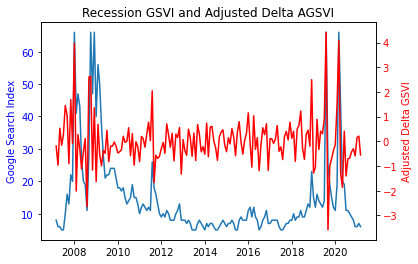

Mean: 0.000000, StandardDeviation: 0.276017


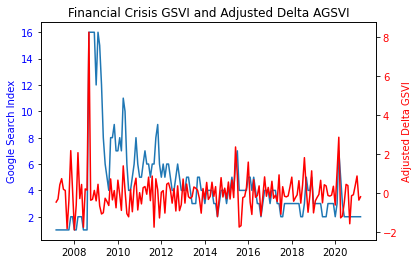

Mean: 0.000000, StandardDeviation: 0.382856


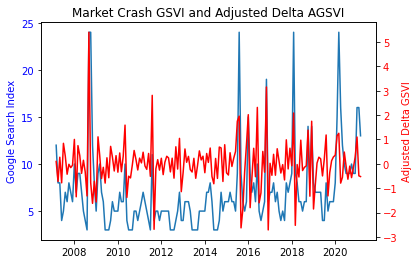

Mean: 0.000000, StandardDeviation: 0.144901


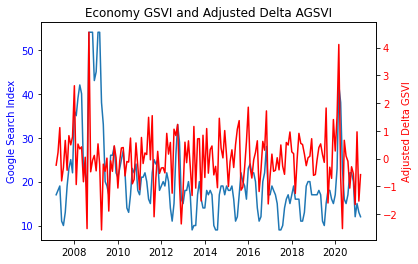

In [326]:
# Apply fearsindex() function to compute all values required to calculate the fears index
data1 = fearsindex_df(dt)

In [327]:
# Check if the table has the correct format (Beware It gonna be a Large Table!)
pd.set_option('display.max_columns', None)
data1

,Recession,Financial Crisis,Market Crash,Economy,isPartial,t,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Recession_deltaGSVI,Recession_deltaGSVI_residual,Recession_Adjusted_deltaGSVI,Financial Crisis_deltaGSVI,Financial Crisis_deltaGSVI_residual,Financial Crisis_Adjusted_deltaGSVI,Market Crash_deltaGSVI,Market Crash_deltaGSVI_residual,Market Crash_Adjusted_deltaGSVI,Economy_deltaGSVI,Economy_deltaGSVI_residual,Economy_Adjusted_deltaGSVI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-03-01,8,1,12,17,False,1,0,1,0,0,0,0,0,0,0,0,0,0.000000,-0.057215,-0.189417,0.000000,-0.126899,-0.459751,0.000000,0.036247,0.094674,0.000000,-0.034799,-0.240154
2007-04-01,6,1,8,18,False,2,0,0,1,0,0,0,0,0,0,0,0,-0.287682,-0.291753,-0.965884,0.000000,-0.082959,-0.300557,-0.405465,-0.276645,-0.722582,0.057158,0.031053,0.214307
2007-05-01,6,1,8,19,False,3,0,0,0,1,0,0,0,0,0,0,0,0.000000,0.160609,0.531716,0.000000,0.116898,0.423517,0.000000,0.103217,0.269596,0.054067,0.161457,1.114252
2007-06-01,5,1,4,11,False,4,0,0,0,0,1,0,0,0,0,0,0,-0.182322,-0.047852,-0.158420,0.000000,0.204404,0.740549,-0.693147,-0.299142,-0.781342,-0.546544,-0.116885,-0.806652
2007-07-01,5,1,5,10,False,5,0,0,0,0,0,1,0,0,0,0,0,0.000000,0.082367,0.272685,0.000000,0.054162,0.196228,0.223144,0.321767,0.840437,-0.095310,-0.046321,-0.319673
2007-08-01,10,1,7,13,False,6,0,0,0,0,0,0,1,0,0,0,0,0.693147,0.438078,1.450308,0.000000,0.037115,0.134466,0.336472,0.121101,0.316309,0.262364,0.094560,0.652584
2007-09-01,16,1,6,19,False,7,0,0,0,0,0,0,0,1,0,0,0,0.470004,0.318822,1.055497,0.000000,-0.502988,-1.822307,-0.154151,-0.163917,-0.428143,0.379490,-0.061478,-0.424274
2007-10-01,13,1,8,23,False,8,0,0,0,0,0,0,0,0,1,0,0,-0.207639,-0.272803,-0.903147,0.000000,-0.106489,-0.385805,0.287682,-0.007783,-0.020329,0.191055,0.119500,0.824697
2007-11-01,22,2,7,25,False,9,0,0,0,0,0,0,0,0,0,1,0,0.526093,0.511471,1.693285,0.693147,0.600488,2.175547,-0.133531,-0.060223,-0.157298,0.083382,0.071283,0.491940


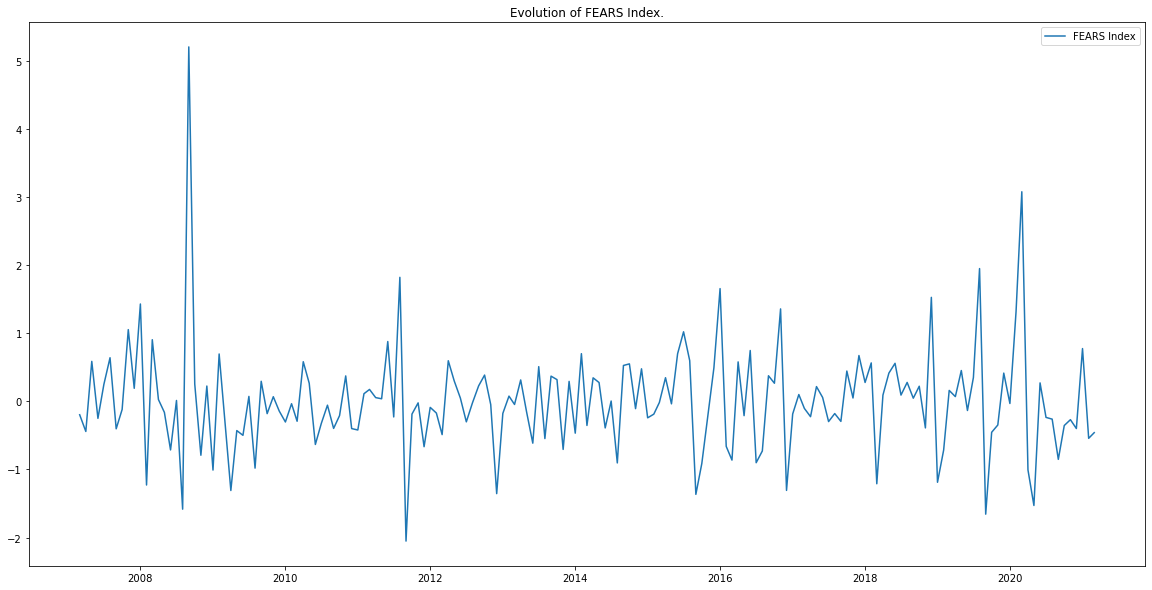

In [328]:
data1 = fears(data1)

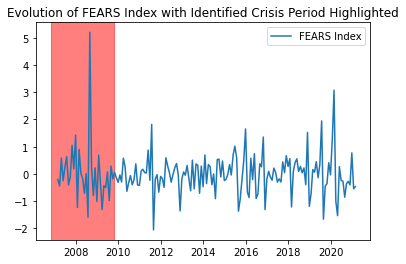

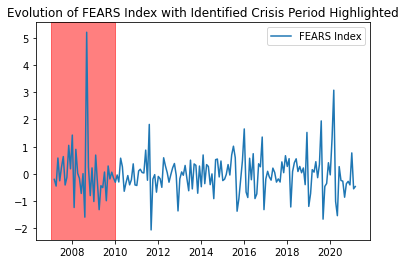

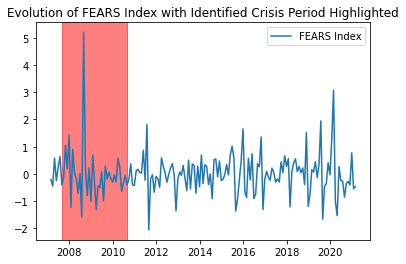

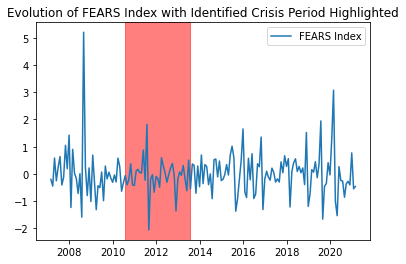

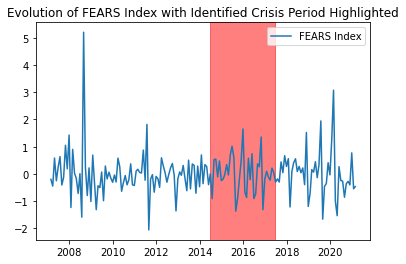

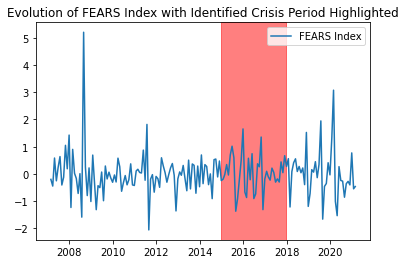

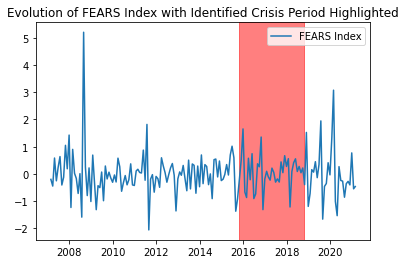

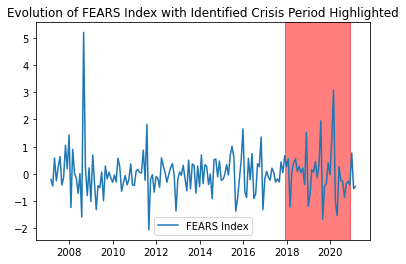

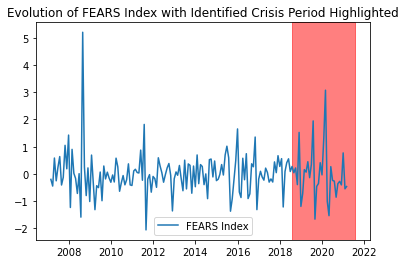

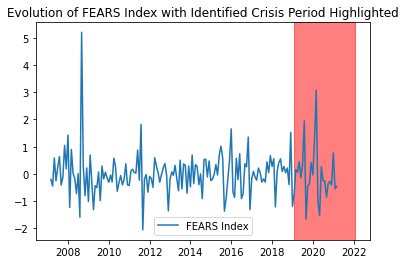

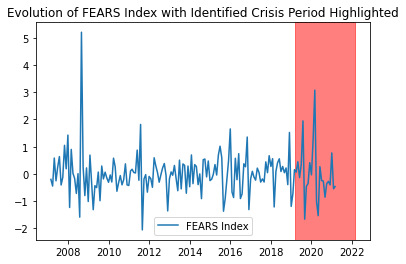

In [329]:
crisis_period = crisis(data1)

In [330]:
# Check if the table has the correct format 
crisis_period

,Crisis Date,Start,End
0,2007-11-01,2006-11-02,2009-10-29
1,2008-01-01,2007-01-02,2009-12-29
2,2008-09-01,2007-09-03,2010-08-30
3,2011-08-01,2010-08-02,2013-07-29
4,2015-07-01,2014-07-02,2017-06-28
5,2016-01-01,2015-01-02,2017-12-29
6,2016-11-01,2015-11-03,2018-10-30
7,2018-12-01,2017-12-02,2020-11-28
8,2019-08-01,2018-08-02,2021-07-29
9,2020-02-01,2019-02-02,2022-01-29


# Sentiment Analysis - Reddit

## Detection Formula

In [331]:
# Define the Hypothesis Function
def HTS(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [332]:
# Define the Anomaly Detection Function.
def FindAnomaly_S(GME_count_Reddit, size = 5): ### size: window size (default = 5)
    if len(GME_count_Reddit) < size:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            print("Date:", GME_count_Reddit['Date'][i+size]) ###
            pval = HTS(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [333]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly_S(GME_count_Reddit, vr, size):
    anomaly = {'Date':[], 
               vr:[]}
    if len(GME_count_Reddit) < size+5:
        print("Not enough data.")
    else:
        for i in range(len(GME_count_Reddit)-(2*size-1)):
            ref_W = GME_count_Reddit['Count'][i:i+size]
            det_W = GME_count_Reddit['Count'][i+size:i+2*size]
            pval = HTS(ref_W, det_W)
            if pval < 0.05:
                anomaly['Date'].append(GME_count_Reddit['Date'][i+size]) ###
                anomaly[vr].append(GME_count_Reddit['Count'][i+size]) ###
    return anomaly

## Compute Volume of Sentiments

In [334]:
# Dataframe Display Configuration
pd.set_option('display.max_rows', 500)

# IMPORTANT: Change REDDIT Sentiment INPUT Here

In [420]:
# Read the Combined Data
# R_sen = pd.read_excel(r'Data\Reddit_NOKIA_sentiments.xlsx')
R_sen = pd.read_csv(r'Data\Reddit_DJ_Sentiments.csv') ### Use this one for CSV files (GME, SP, DJ)

# #################################

In [421]:
# Convert Date to datetime Format
R_sen['Date'] = pd.to_datetime(R_sen['Date'])

In [422]:
R_sen

,created_utc,title,url,Date
0,1614393892,GME may have the potential to dictate the cour...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 02:44:52
1,1614346424,(2/26) Friday's Pre-Market Stock Movers &amp; ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-26 13:33:44
2,1614277744,"Could GME$ be the new Dow Jones,S&amp;P 500 an...",https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 18:29:04
3,1614268086,"They say “GMC, AMC, GameStop!” I say... “Dow J...",https://v.redd.it/jl46bd99anj61,2021-02-25 15:48:06
4,1614215894,Catching back up to the DOW Jones,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 01:18:14
5,1614212957,Dow Jones (US30),https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 00:29:17
6,1614211119,"Dow Jones newswire mentions DFV, claims only 3...",https://i.redd.it/vy1bqnewkij61.jpg,2021-02-24 23:58:39
7,1614192263,Relief Package and Implications for Stock Market,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-24 18:44:23
8,1614088852,(2/23) Tuesday's Pre-Market Stock Movers &amp;...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-23 14:00:52
9,1614049755,$2900 profit in 7 days from $5k deposit tradin...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-23 03:09:15


In [423]:
# Delete Duplicate
R_sen.drop_duplicates(subset = ["title", "url"], keep = False, inplace = True)

In [424]:
# Check Data
R_sen

,created_utc,title,url,Date
0,1614393892,GME may have the potential to dictate the cour...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-27 02:44:52
1,1614346424,(2/26) Friday's Pre-Market Stock Movers &amp; ...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-26 13:33:44
2,1614277744,"Could GME$ be the new Dow Jones,S&amp;P 500 an...",https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 18:29:04
3,1614268086,"They say “GMC, AMC, GameStop!” I say... “Dow J...",https://v.redd.it/jl46bd99anj61,2021-02-25 15:48:06
4,1614215894,Catching back up to the DOW Jones,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 01:18:14
5,1614212957,Dow Jones (US30),https://www.reddit.com/r/wallstreetbets/commen...,2021-02-25 00:29:17
6,1614211119,"Dow Jones newswire mentions DFV, claims only 3...",https://i.redd.it/vy1bqnewkij61.jpg,2021-02-24 23:58:39
7,1614192263,Relief Package and Implications for Stock Market,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-24 18:44:23
8,1614088852,(2/23) Tuesday's Pre-Market Stock Movers &amp;...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-23 14:00:52
9,1614049755,$2900 profit in 7 days from $5k deposit tradin...,https://www.reddit.com/r/wallstreetbets/commen...,2021-02-23 03:09:15


In [425]:
# Sort by Date
R_sen = R_sen.sort_values('Date')

In [426]:
# Keep the Columns needed and Reset Index
R_sen_sort = R_sen[['Date', 'title', 'url']].reset_index()
del R_sen_sort['index']

In [427]:
# Rename the column names to 
R_sen_sort.rename(columns={"title": "Title"})

,Date,Title,url
0,2019-08-02 14:56:54,"For the past year, the Dow Jones has been pret...",https://www.reddit.com/r/wallstreetbets/commen...
1,2019-08-03 03:34:29,"What a cluster fuck this week has been,",https://www.reddit.com/r/wallstreetbets/commen...
2,2019-08-14 07:18:00,what in tarnations is this Dow Jones youtube a...,https://www.reddit.com/r/wallstreetbets/commen...
3,2019-08-27 17:09:55,Afternoon Briefing (8/27/2019),https://www.reddit.com/r/wallstreetbets/commen...
4,2019-08-29 02:42:50,Trump’s Tweets Cost Investors Over $500 Billion,https://www.reddit.com/r/wallstreetbets/commen...
5,2019-09-09 21:21:30,TD Ameritrade Investor Movement Index (IMX) - ...,https://www.reddit.com/r/wallstreetbets/commen...
6,2019-09-17 19:23:42,Options market 9-17-19,https://www.reddit.com/r/wallstreetbets/commen...
7,2019-09-26 21:51:43,Lost 66k shorting the Dow Jones. Bought 202 pu...,https://i.redd.it/ja1uo6sve0p31.png
8,2019-10-02 16:35:36,"Prune your stocks, Activision Blizzard, Inc. (...",https://youtu.be/4-AhG5NBjtk
9,2019-10-03 14:05:15,Dow Jones Dropping Even Further,https://www.reddit.com/r/wallstreetbets/commen...


In [428]:
# Count Posts Group By Dates
# Attribute: https://stackoverflow.com/questions/52182967/python-pandas-group-by-date-and-count
# Author: jezrael

R_count_Reddit = R_sen_sort['Date'].dt.date.value_counts().sort_index().reset_index()

In [429]:
# Rename Dataframe
R_count_Reddit = R_count_Reddit.rename(columns={"index": "Date", "Date": "Count"})

In [430]:
# Remove Extra Data Points
R_count_Reddit['Date'] = pd.to_datetime(R_count_Reddit['Date'])
R_count_Reddit = R_count_Reddit[~(R_count_Reddit['Date'] > '2021-02-11')]

Text(0.5, 1.0, 'Daily Count of Related Posts in r/WallStreetBets')

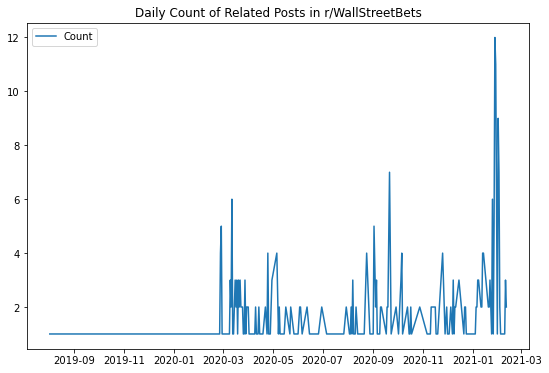

In [431]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(R_count_Reddit.Date, R_count_Reddit.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Posts in r/WallStreetBets')

In [432]:
# Run the Detection Method
FindAnomaly_S(R_count_Reddit)

Date: 2019-09-09 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-09-17 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-09-26 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-02 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-03 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-13 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-14 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-15 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-19 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-25 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-10-26 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-11-11 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-11-23 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-12-04 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2019-12-06 00:00:00
The p-value is: nan
No Anomlay Detec

In [433]:
# Record Unusual Investor Attention
R_Anomaly = RecordAnomaly_S(R_count_Reddit, "Unusual Investor Attention", 5)
Reddit_Anomaly = pd.DataFrame(R_Anomaly)
display(Reddit_Anomaly)

,Date,Unusual Investor Attention
0,2020-04-02,1
1,2020-04-03,1
2,2020-12-24,1
3,2021-01-04,1
4,2021-01-05,2
5,2021-01-06,2
6,2021-01-07,3
7,2021-02-02,7
8,2021-02-03,2


# Sentiment Analysis - Twitter

# IMPORTANT: Change TWITTER Sentiment INPUT Here

In [434]:
# Read the Combined Data (AMC & GME has Part 1 & 2)
# sen_T1 = pd.read_csv(r'Data\GME_Twitter_Part1.csv')
# sen_T2 = pd.read_csv(r'Data\GME_Twitter_Part2.csv')
# sen_T = sen_T1.append(sen_T2, ignore_index=True)

sen_T = pd.read_csv(r'Data\DJ_Twitter.csv') ###

# #################################

In [435]:
# Convert Date to datetime Format
sen_T['Date'] = pd.to_datetime(sen_T['Date'])

In [436]:
# Remove Extra Data Points
sen_T['Date'] = pd.to_datetime(sen_T['Date'])
sen_T = sen_T[~(sen_T['Date'] > '2021-02-11')]

In [437]:
# Rename Dataframe
sen_T = sen_T.rename(columns={"Frequency": "Count"})

In [438]:
sen_T

,Date,Count
0,2019-08-02,53
1,2019-08-03,13
2,2019-08-04,15
3,2019-08-05,288
4,2019-08-06,131
...,...,...
555,2021-02-07,12
556,2021-02-08,36
557,2021-02-09,70
558,2021-02-10,48


Text(0.5, 1.0, 'Daily Count of Related Tweets on Twitter')

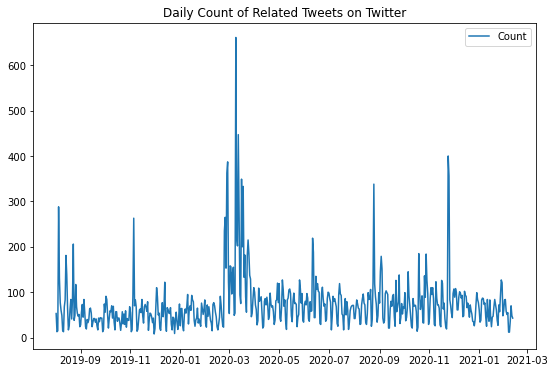

In [439]:
# Visulisation
pp.figure(figsize=(9,6))
pp.plot(sen_T.Date, sen_T.Count, label = 'Count')
pp.legend(loc = 'best')
pp.title('Daily Count of Related Tweets on Twitter')

In [440]:
# Run the Detection Method
FindAnomaly_S(sen_T)

Date: 2019-08-07 00:00:00
The p-value is: 0.31311646175582963
No Anomlay Detected.
Date: 2019-08-08 00:00:00
The p-value is: 0.2549206519654573
No Anomlay Detected.
Date: 2019-08-09 00:00:00
The p-value is: 0.2013508612430594
No Anomlay Detected.
Date: 2019-08-10 00:00:00
The p-value is: 0.3878123607749272
No Anomlay Detected.
Date: 2019-08-11 00:00:00
The p-value is: 0.40965397086025324
No Anomlay Detected.
Date: 2019-08-12 00:00:00
The p-value is: 0.039378290642698724
Anomaly Pattern Detected!!!!!
Date: 2019-08-13 00:00:00
The p-value is: 0.1091796261034896
No Anomlay Detected.
Date: 2019-08-14 00:00:00
The p-value is: 0.2904834887967147
No Anomlay Detected.
Date: 2019-08-15 00:00:00
The p-value is: 0.7875412146051782
No Anomlay Detected.
Date: 2019-08-16 00:00:00
The p-value is: 0.18567649265286254
No Anomlay Detected.
Date: 2019-08-17 00:00:00
The p-value is: 0.04720953156354519
Anomaly Pattern Detected!!!!!
Date: 2019-08-18 00:00:00
The p-value is: 0.2684106651836088
No Anomlay De

The p-value is: 0.48222100758577024
No Anomlay Detected.
Date: 2020-05-06 00:00:00
The p-value is: 0.5357086669957811
No Anomlay Detected.
Date: 2020-05-07 00:00:00
The p-value is: 0.437978467403199
No Anomlay Detected.
Date: 2020-05-08 00:00:00
The p-value is: 0.3880752055670066
No Anomlay Detected.
Date: 2020-05-09 00:00:00
The p-value is: 0.256297957939551
No Anomlay Detected.
Date: 2020-05-10 00:00:00
The p-value is: 0.8565254692747383
No Anomlay Detected.
Date: 2020-05-11 00:00:00
The p-value is: 0.07855285142429545
No Anomlay Detected.
Date: 2020-05-12 00:00:00
The p-value is: 0.10577131635347786
No Anomlay Detected.
Date: 2020-05-13 00:00:00
The p-value is: 0.4410357529570187
No Anomlay Detected.
Date: 2020-05-14 00:00:00
The p-value is: 0.7336666621503731
No Anomlay Detected.
Date: 2020-05-15 00:00:00
The p-value is: 0.6954516677343594
No Anomlay Detected.
Date: 2020-05-16 00:00:00
The p-value is: 0.04869254208506421
Anomaly Pattern Detected!!!!!
Date: 2020-05-17 00:00:00
The p

Anomaly Pattern Detected!!!!!
Date: 2020-12-24 00:00:00
The p-value is: 0.11003873440522556
No Anomlay Detected.
Date: 2020-12-25 00:00:00
The p-value is: 0.9275574201365554
No Anomlay Detected.
Date: 2020-12-26 00:00:00
The p-value is: 0.414866787172502
No Anomlay Detected.
Date: 2020-12-27 00:00:00
The p-value is: 0.022223919710701923
Anomaly Pattern Detected!!!!!
Date: 2020-12-28 00:00:00
The p-value is: 0.0006761095507547954
Anomaly Pattern Detected!!!!!
Date: 2020-12-29 00:00:00
The p-value is: 0.06417240886066418
No Anomlay Detected.
Date: 2020-12-30 00:00:00
The p-value is: 0.8010944962581316
No Anomlay Detected.
Date: 2020-12-31 00:00:00
The p-value is: 0.7481604842161965
No Anomlay Detected.
Date: 2021-01-01 00:00:00
The p-value is: 0.37472119017741035
No Anomlay Detected.
Date: 2021-01-02 00:00:00
The p-value is: 0.36951534223475024
No Anomlay Detected.
Date: 2021-01-03 00:00:00
The p-value is: 0.8717678530875395
No Anomlay Detected.
Date: 2021-01-04 00:00:00
The p-value is: 

In [441]:
# Record Unusual Investor Attention
T_Anomaly = RecordAnomaly_S(sen_T, "Unusual Investor Attention", 5)
Twitter_Anomaly = pd.DataFrame(T_Anomaly)
display(Twitter_Anomaly)

,Date,Unusual Investor Attention
0,2019-08-12,68
1,2019-08-17,17
2,2019-09-02,56
3,2019-09-07,24
4,2019-09-30,74
5,2019-11-23,16
6,2019-12-02,66
7,2019-12-21,29
8,2020-01-17,79
9,2020-01-18,38


# Format Data

### Read from CSV

In [442]:
# define formating function
def format_csv(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[['Adj Close']] ### drop all other columns
    df['Return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

In [443]:
def format_csv2(csv_title):
    df = pd.read_csv(csv_title, index_col = 'Date') ### data as index 
    df = df[[' Close']] ### drop all other columns
    df['Return'] = (df[' Close'] / df[' Close'].shift(1)) - 1 ### compute return
    df['Return'] = df['Return'].fillna(0) ### replace NaN with 0
    df.index = pd.to_datetime(df.index) ### datatype conversion
    return df

## Detrend & Smoothing

### Log Transformation & Detrend

In [444]:
# Attribute: https://github.com/srafay/Time-Series-Analysis-JetRail/blob/f5c25f4d481ddb8deaea09f2cff2d8585dcf6bb4/Jet_Rail.py#L197
# Author: Syed Rafay
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def test_stationarity(timeseries, w, title='Rolling Mean & Standard Deviation'): ### w: window size
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=w).mean()
    rolstd = timeseries.rolling(center=False,window=w).std()
    #Plot rolling statistics:
    pp.figure(figsize=(20,10))
    orig = pp.plot(timeseries, color='blue',label='Original')
    mean = pp.plot(rolmean, color='red', label='Rolling Mean')
    std = pp.plot(rolstd, color='green', label = 'Rolling Std')
    pp.legend(loc='best')
    pp.title(title)
    pp.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def detrend_takelog(df, w): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    moving_avg = Train_log.rolling(w).mean()
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.plot(df.index.values, moving_avg.values, color = 'red', label='Rolling_Mean(log(train))')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    # Remove the trend
    train_log_moving_avg_diff = Train_log - moving_avg
    ### option 1: NaN replaced by 0
    ### train_log_moving_avg_diff = train_log_moving_avg_diff.fillna(0) 
    ### option 2: drop NaN
    train_log_moving_avg_diff.dropna(inplace = True)
    test_stationarity(train_log_moving_avg_diff, w) # And from plot we can see that std is stable
    return train_log_moving_avg_diff.to_frame()

### Log Transformation

In [445]:
def takelog(df, w = 5): ### df: dt['']; w: window size 
    # plot raw data 
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, df.values)
    pp.title('Original Time Series Data')
    pp.show()
    # log transormation
    Train_log = np.log(df['Adj Close'])
    # plot logged trainning data
    pp.figure(figsize=(20,10))
    pp.plot(df.index.values, Train_log.values, label='log(train)')
    pp.legend(loc='best')
    pp.title('Transforming series by taking the log')
    pp.show()
    test_stationarity(Train_log, w) # And from plot we can see that std is stable
    return Train_log.to_frame()

In [446]:
# Random-Walk Model Synthetic Data
### Check cosine similarity measure - Euclidean Distance b/w two points/vector.

# Machine Learning


## Define Functions

In [447]:
# Define Transformation Function that converts data into t chunks of equal length - for Adjusted Close Price
def transform(df_t, va, t): ### df_t: time-series data, va: variable, t: length of chunks
    X_array = np.array(df_t[[va]].dropna(inplace = False)) ### Convert X into Array
    residue = len(X_array) % t
    if residue:
        print("The array is not divisible into a", t, "dimensional array.")
        print("We omit the first", residue, "entry/entries in the dataset.")
    X_array = X_array[residue:] ### Crop the data into length divisible by t
    X_t = np.reshape(X_array, (-1, t)) ### Reshape for fitting
    return X_t

In [448]:
# Define Model Fit Function - Training
def DTWfit(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [449]:
# Define Distance Function
def dtw_dist(x, y):
    distance, path = fastdtw(x, y, dist = euclidean)
    return distance

In [450]:
# Define Threshold Function - Training
def find_threshold(X_t, m = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = model_X.cluster_centers_
    XL = model_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = m * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    print("The inter-quartile range is", iqr, ".")
    print("The max-distance threshold for a new data point to be not classifed as an outlier is", X_threshold, ".")
    print("The full distance matrixs are with a size of", len(XDM), ":")
    print(np.reshape(XDM, (-1)))
    return X_threshold

In [451]:
# Rolling window for data streaming mode (note: this step only models the streaming process using method of iteration, 
# it should not to be applied directly to an actual data stream)
def window(seq, n = 5): ### n: size of the window
    it = iter(seq)
    win = tuple(islice(it, n))
    if len(win) == n:
        yield np.array(win)
    for e in it:
        win = win[1:] + (e,)
        yield np.array(win)

In [452]:
# Define Labelling Function Component
def Label(X_in, Threshold): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = model_X.cluster_centers_
    j = model_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (5,1)), d_X[j]) ###
    print("The distance is:", d)
    if d > Threshold:
        return 1
    else:
        return 0

In [453]:
# Define Labelling Function
def labeling_X(inputs, threshold, X_lb): ### inputs: Data to be detected, X_lb: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(5, 1)
        tl = Label(nt, threshold)
        X_lb.append(tl)
        print("Time series:")
        print(nt)
        print("is labeled as", tl, ".")
        print("Current labels are:")
        print(X_lb)

In [454]:
# Define the Hypothesis Function
def HT(array1, array2): ### ref: reference window, det: detection window
    ref = array1
    det = array2 ### These two lines are reserved for easy change to a different HT function.
    tset, pval = stats.ttest_ind(det, ref)
    return pval

In [455]:
# Define the Anomaly Detection Function.
def FindAnomaly(X_lb, size): ### size: window size (default = 5)
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            print("Date:", X.index[i+size]) ###
            pval = HT(ref_W, det_W)
            print("The p-value is:", pval)
            if pval < 0.05:
                print("Anomaly Pattern Detected!!!!!")
            else:
                print("No Anomlay Detected.")

In [456]:
# Define the Record Anomaly Function. (This function will store all the anomalies into a dataframe)
def RecordAnomaly(X_lb, vr, size):
    Anomaly = {'Date':[], 
               vr:[]}
    if len(X_lb) < size:
        print("Not enough data.")
    else:
        ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                Anomaly['Date'].append(X.index[i+size]) ###
                Anomaly[vr].append(X[i+size]) ###
    return Anomaly

In [457]:
# Define Function that signals the first Anomaly Pattern Instance
def SignalAnomaly(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05:
                return X.index[i+size] ###

In [458]:
# Visualisation for DTW

### Attribute: https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py
### Arthor: M. Cuturi, M. Blondel “Soft-DTW: a Differentiable Loss Function for Time-Series,” ICML 2017.
# 2nd Attribute: Recommended & Reviewed by
# Author: Zhaolin

def visualise_clustering(X_train, ts):
    lens = len(model_X.cluster_centers_)
    sz = X_train.shape[1]-1
    print("DTW k-means")
    y_pred = model_X.predict(X_train)
    print("Labels:")
    print(model_X.labels_)
    pp.figure(figsize = (10, 10))
    for yi in range(lens):
        pp.subplot(3, lens, 1 + yi)
        for xx in X_train[y_pred == yi]:
            pp.plot(xx.ravel(), "k-", alpha = .2)
        pp.plot(model_X.cluster_centers_[yi].ravel(), "r-")
        pp.xlim(0, sz)
        pp.ylim(ts.min(), ts.max()) ### range needs to be customizable
        pp.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform = pp.gca().transAxes)
        if yi == 1:
            pp.title("DTW $k$-means")
    pp.tight_layout()
    pp.show()
    return

In [459]:
# Visualisation for Anomaly Pattern Signal
def plotAnomaly(df, vr): ### df: dataframe, vr: variable "Adj Close", "Return"..., lb: Label ""
    pp.figure(figsize = (20, 10))
    pp.plot(df[vr], label = vr)
    if len(Anomaly_Table) > 0:
        pp.axvline(x = Anomaly_Table['Date'][0], color = 'red', label = Anomaly_Table['Date'][0])
        pp.axhline(y = Anomaly_Table[vr][0], color = 'red', label = Anomaly_Table[vr][0])
    pp.legend(loc='best')
    pp.title('Anomaly Pattern Signal')
    pp.show
    print("1st Anomaly Instance Detected at:", Anomaly_Table.head(1))

# Normalised Return; Daily

This part of the modelling is completed with the following data structure:

**Training Data**
- Period: 01/08/2019 - 31/08/2020
- Length: 273
- Interval: daily
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes

**Testing Data**
- Period: 01/09/2020 - 11/02/2021
- Length: 106
- Interval: daily
- Attribute: Adj Close
- Log: Yes
- Detrend: Yes


## DTW K-mean Clustering - Training

# IMPORTANT: Change TRAINING data INPUT Here

In [460]:
# Read GME Training Data
# df_train = format_csv(r'Data\NOK_train.csv')

df_train = format_csv2(r'Data\DJ_train.csv')

# #################################

In [461]:
# Check data has loaded correctly
df_train

,Close,Return
Date,,
2020-08-31,28430.05,0.000000
2020-08-28,28653.87,0.007873
2020-08-27,28492.27,-0.005640
2020-08-26,28331.92,-0.005628
2020-08-25,28248.44,-0.002946
2020-08-24,28308.46,0.002125
2020-08-21,27930.33,-0.013357
2020-08-20,27739.73,-0.006824
2020-08-19,27692.88,-0.001689


In [462]:
# Transform the data.
X_t = transform(df_train, 'Return', 5)

In [463]:
# Check the data has transformed correctly
X_t

array([[ 0.00000000e+00,  7.87265587e-03, -5.63972685e-03,
        -5.62784222e-03, -2.94649992e-03],
       [ 2.12471910e-03, -1.33574910e-02, -6.82412274e-03,
        -1.68891334e-03,  3.07624198e-03],
       [ 2.40621469e-03,  3.09248620e-03, -1.22802533e-03,
         2.87202223e-03, -1.03632147e-02],
       [ 3.77543034e-03, -1.28802250e-02, -1.69500916e-03,
        -6.77183099e-03, -1.37143071e-02],
       [-6.11551833e-03, -8.85375257e-03, -4.33890614e-03,
         8.58565801e-03, -6.03966078e-03],
       [ 7.78982595e-03, -4.32127116e-03,  6.89235958e-03,
         1.32637559e-02, -6.12608236e-03],
       [-5.94365211e-03, -3.34321932e-04,  2.35303381e-03,
         5.06420305e-03, -8.46703213e-03],
       [-2.08984937e-02, -4.02517845e-04, -1.41593769e-02,
         1.40507561e-02, -6.79395779e-03],
       [ 1.53282055e-02, -1.74865704e-02, -3.57721424e-03,
         3.02739813e-03, -8.40975513e-03],
       [-2.26697349e-02,  2.91838476e-02, -1.16392704e-02,
         2.79085779e-02

## DTW Varient Here

# IMPORTANT: Change k Here

In [464]:
# assign DTWfit(X_t) parameters
number_of_clusters = 4
algorithm = "dtw" ### "dtw" or "euclidean" (distance computation method)
min_size = int(X_t.shape[0] * 0.05) ### cluster with less than 5% of total sample

# #################################

In [465]:
# Fit the traning data.
model_X = DTWfit(X_t)
model_X.cluster_centers_ ### Check the cluster centroids

1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.


array([[[-0.00238619],
        [ 0.00085562],
        [-0.01236989],
        [ 0.01382994],
        [-0.00069934]],

       [[-0.00937264],
        [ 0.06726295],
        [-0.04938745],
        [ 0.14845566],
        [-0.08561341]]])

DTW k-means
Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


C:\Users\senyu\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 55 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


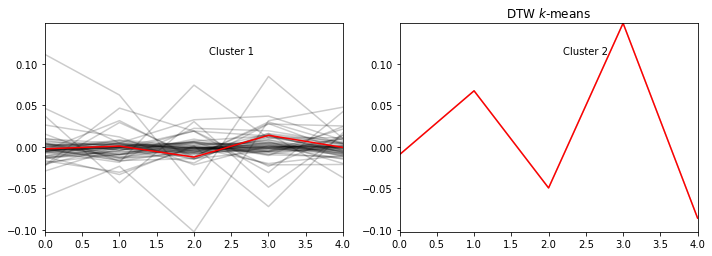

In [466]:
# DTW Visualisation
visualise_clustering(X_t, df_train['Return'])

### note: because the detrended data using log and moving average will result in extremely small values, which will lead
###       to similar cluster centroids more often than original data.

In [467]:
# Find Threshold and save the value
Threshold = find_threshold(X_t, 1)

The max distance found is 0.29019499460403125 .
The inter-quartile range is 0.029583960902587702 .
The max-distance threshold for a new data point to be not classifed as an outlier is 0.29019499460403125 .
The full distance matrixs are with a size of 55 :
[0.03368504 0.03160782 0.03879294 0.04420418 0.03205428 0.03633204
 0.03600375 0.02787535 0.06336222 0.06773544 0.05125243 0.09231662
 0.08548091 0.06392008 0.04737996 0.02616822 0.03943766 0.07547314
 0.05751654 0.07168797 0.12139152 0.16272918 0.23726688 0.
 0.29019499 0.16098008 0.11956128 0.02912984 0.03544709 0.0473235
 0.01771512 0.03410091 0.0280312  0.03294957 0.0260097  0.02536053
 0.02325941 0.03926889 0.04796482 0.02967238 0.02958526 0.02674397
 0.03840733 0.02793335 0.03156263 0.02769147 0.03377373 0.02213171
 0.03722812 0.02482844 0.01233875 0.05881242 0.03359761 0.03888145
 0.03250193]


## DTW - Prediction

### Setting-up Testing Environment

# IMPORTANT: Change TESTING data INPUT Here

In [468]:
# Read AMC Testing Data
# df_test = format_csv(r'Data\GME.csv')

df_test = format_csv2(r'Data\DJ.csv')

# #################################

In [469]:
# Remove Extra Data Points
df_test = df_test[~(df_test.index > '2021-02-11')]

In [470]:
# Select the data to be predicted by the model: "Adj Close" or "Return" (Remember to drop nan when using detrended data)
X = df_test['Return'].dropna(inplace = False) ### DO NOT RENAME X or it will cause date report error!
print("The data going to apply to the testing model are:", X)

The data going to apply to the testing model are: Date
2021-02-11   -0.000881
2021-02-10    0.000226
2021-02-09   -0.001971
2021-02-08    0.000316
2021-02-05   -0.007568
2021-02-04   -0.002966
2021-02-03   -0.010699
2021-02-02   -0.001176
2021-02-01   -0.015497
2021-01-29   -0.007589
2021-01-28    0.020703
2021-01-27   -0.009809
2021-01-26    0.020918
2021-01-25    0.000742
2021-01-22    0.001194
2021-01-21    0.005776
2021-01-20    0.000397
2021-01-19   -0.008268
2021-01-15   -0.003759
2021-01-14    0.005753
2021-01-13    0.002225
2021-01-12    0.000265
2021-01-11   -0.001931
2021-01-08    0.002879
2021-01-07   -0.001828
2021-01-06   -0.006821
2021-01-05   -0.014201
2021-01-04   -0.005518
2020-12-31    0.012659
2020-12-30   -0.006434
2020-12-29   -0.002430
2020-12-28    0.002251
2020-12-24   -0.006713
2020-12-23   -0.002319
2020-12-22   -0.003794
2020-12-21    0.006695
2020-12-18   -0.001238
2020-12-17    0.004119
2020-12-16   -0.004911
2020-12-15    0.001485
2020-12-14   -0.011184
20

In [471]:
# Setting up
mylist = iter(window(X)) # Convert the np.Array into iterations to represent the streaming data environment.
X_lb = [] ### Create the Array for the result to be stored 

### Perform the Test to find Anomaly Pattern

In [472]:
# Single Exercution
# labeling_X(mylist, Threshold, X_lb)

In [473]:
# Fast Exercution
for i in range (len(list(window(X)))):
    labeling_X(mylist, Threshold, X_lb)

The distance is: 0.032915966361910326
Time series:
[[-0.00088053]
 [ 0.00022589]
 [-0.00197119]
 [ 0.00031649]
 [-0.00756776]]
is labeled as 0 .
Current labels are:
[0]
The distance is: 0.027430584240475522
Time series:
[[ 0.00022589]
 [-0.00197119]
 [ 0.00031649]
 [-0.00756776]
 [-0.00296582]]
is labeled as 0 .
Current labels are:
[0, 0]
The distance is: 0.03255146530448019
Time series:
[[-0.00197119]
 [ 0.00031649]
 [-0.00756776]
 [-0.00296582]
 [-0.01069879]]
is labeled as 0 .
Current labels are:
[0, 0, 0]
The distance is: 0.02885867843403061
Time series:
[[ 0.00031649]
 [-0.00756776]
 [-0.00296582]
 [-0.01069879]
 [-0.00117564]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0]
The distance is: 0.04047755532565795
Time series:
[[-0.00756776]
 [-0.00296582]
 [-0.01069879]
 [-0.00117564]
 [-0.0154972 ]]
is labeled as 0 .
Current labels are:
[0, 0, 0, 0, 0]
The distance is: 0.042360163930170065
Time series:
[[-0.00296582]
 [-0.01069879]
 [-0.00117564]
 [-0.0154972 ]
 [-0.00758939]]
i

In [474]:
# Find the Anomalies
FindAnomaly(X_lb, 5)

Date: 2021-02-04 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-02-03 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-02-02 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-02-01 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-29 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-28 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-27 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-26 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-25 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-22 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-21 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-20 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-19 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-15 00:00:00
The p-value is: nan
No Anomlay Detected.
Date: 2021-01-14 00:00:00
The p-value is: nan
No Anomlay Detec

In [475]:
# Record the Anomalies & First Record of Anomaly Pattern
Anomaly = RecordAnomaly(X_lb, "Return", 5)
Anomaly_Table = pd.DataFrame(Anomaly)
display(Anomaly_Table) ### Just so it looks pretty!

,Date,Return


In [476]:
# Signal the First Instance
SignalAnomaly(X_lb, 5)

1st Anomaly Instance Detected at: Empty DataFrame
Columns: [Date, Return]
Index: []


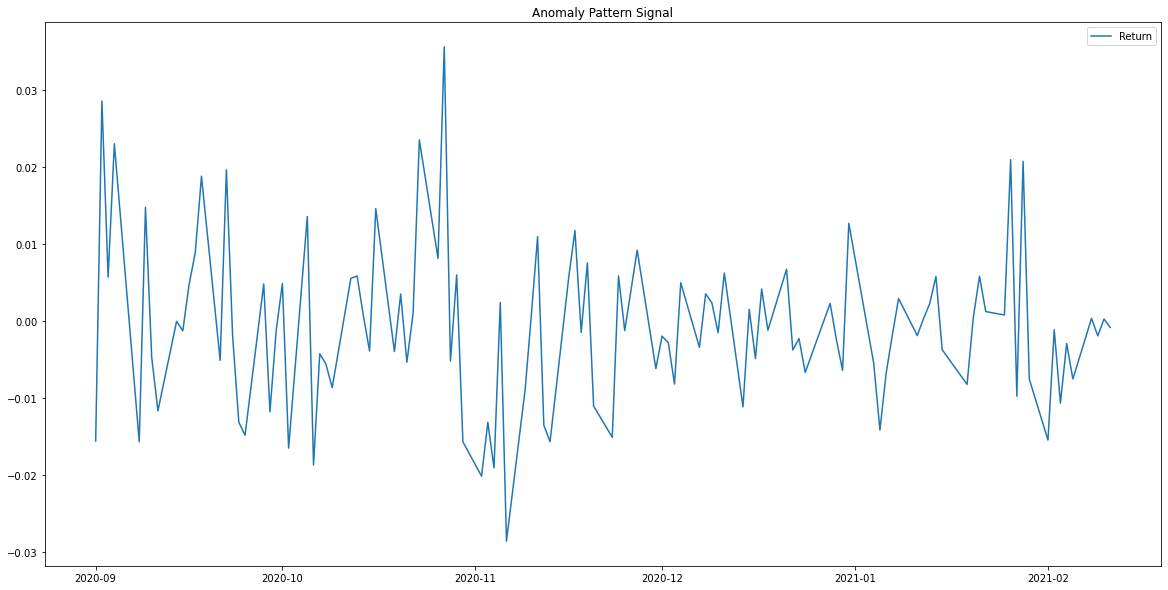

In [477]:
# Visulisation of the Anomaly Signal
plotAnomaly(df_test, "Return")

# Verification

In [478]:
# Check Date in Range for Reddit
def check_range_R(start, end):
    for i in range(len(Reddit_Anomaly['Date'])):
        if start <= Reddit_Anomaly['Date'][i] <= end:
            return 1

In [479]:
# Check Date in Range for Twitter
def check_range_T(start, end):
    for i in range(len(Twitter_Anomaly['Date'])):
        if start <= Twitter_Anomaly['Date'][i] <= end:
            return 1

In [480]:
# Check Date in Range for Crisis
def check_C(date):
    for i in range(len(crisis_period)):
        if crisis_period['Start'][i] <= date <= crisis_period['End'][i]:
            return 1

In [481]:
# Define Final Verification Function
def final_verify(data): ### Data = Anomaly_Table['Date']
    Date = []
    Reddit = []
    Twitter = []
    Crisis = []
    for i in range(len(data)):
        r = 0
        tw = 0
        start = data[i] - timedelta(weeks = 4)
        r = check_range_R(start, data[i])
        tw = check_range_T(start, data[i])
        if r == 1 or tw == 1:
            Date.append(data[i])
            Reddit.append(r)
            Twitter.append(tw)
    verified_anomaly = pd.DataFrame({'Date': Date, 'Reddit': Reddit, 'Twitter': Twitter})
    for i in range(len(verified_anomaly)):
        c = 0
        c = check_C(verified_anomaly['Date'][i])
        if c == 1:
            Crisis.append('Yes')
        else:
            Crisis.append('No')
    verified_anomaly['Crisis Environment'] = Crisis
    return verified_anomaly

## Obtain Final Result

In [482]:
# Get Result
final_result = final_verify(Anomaly_Table['Date'])

In [483]:
# Check Result
final_result

,Date,Reddit,Twitter,Crisis Environment


# Evaluation

In [484]:
# def TP function
def TP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if start_date <= Anomaly_Table['Date'][i]:
            count = count + 1
    return count

In [485]:
# def FP function
def FP(start_date):
    count = 0
    for i in range(len(Anomaly_Table)):
        if Anomaly_Table['Date'][i] <= start_date:
            count = count + 1
    return count

In [486]:
# def FN function
def AC(start_date, end_date):
    count = 0
    for i in range(len(X)):
        if start_date <= X.index[i] <= end_date:
            count = count + 1
    return count

In [487]:
# Def Metrics Result Function
def ev_metrics(): # Data = final_result['Date']
    start_date = datetime(2021,1,1)
    end_date = datetime(2021,1,31)
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    tp = TP(start_date)
    fp = FP(start_date)
    fn = Anomalies - tp
    tn = Total - Anomalies - fp
    Accuracy = (tp + tn)/Total
    Percision = tp/(tp + fp)
    Recall = tp/(tp + fn)
    F = 2*(Percision * Recall)/(Percision + Recall)
    print("The evaluation metrics for the result are:")
    print("True Positive:" + str(tp))
    print("False Positive:" + str(fp))
    print("False Negative:" + str(fn))
    print("True Negative:" + str(tn))
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))
    print("#####################")
    print("Accuracy:" + str(Accuracy))
    print("Percision:" + str(Percision))
    print("Recall:" + str(Recall))
    print("F1-score:" + str(F))

In [488]:
# If No Result Found:
def ev_metrics2():
    start_date = datetime(2021,1,1)
    end_date = datetime(2021,1,31)
    Total = len(X)
    Anomalies = AC(start_date, end_date)
    print("Total Number of Anomalies Present:" + str(Anomalies))
    print("Total Number of Data Tested:" + str(Total))

## Metrics Result

In [489]:
# Obtain Evaluation Result
ev_metrics2()

Total Number of Anomalies Present:19
Total Number of Data Tested:113


# Requirement Analysis

In [490]:
# Define Model Fit Function for Iteration Purpose
def DTWfit_i(X_t):
    model_X_temp = TimeSeriesKMeans(n_clusters = number_of_clusters, metric = algorithm, max_iter = 25)
    model_X_temp.fit(X_t) ### Fit the Model
    Xc = model_X_temp.cluster_centers_
    XL = model_X_temp.labels_
    s = min_size ### smallest cluster size
    idx = []
    for i in range(number_of_clusters): ### define functions to find clusters smaller than s
        if np.count_nonzero(XL == i) <= s:
            idx.append(i)
            print(len(idx), "cluster has a size smaller than", s, "and is removed.")
    Xc = np.delete(Xc, idx, axis = 0) ### remove clusters smaller than s
    if len(idx) == 0:
        model_X = model_X_temp
    else:
        model_X = TimeSeriesKMeans(n_clusters = len(Xc), metric = algorithm, max_iter = 25)
        model_X.fit(X_t) ### Fit the model again using updated cluster-size.
    return model_X

In [491]:
# Define Threshold Function for iteration
def find_th(X_t, z = 3): ### X_t is training dataset; m: multiplier (default is 3)
    XDM = []
    d_X = mod_X.cluster_centers_
    XL = mod_X.labels_
    for i in range (len(X_t)): # Compute Union of Distance Matrix
        j = XL[i]
        dist = dtw_dist(X_t[i], d_X[j]) 
        XDM.append(dist)
    q75, q25 = np.percentile(XDM, [75 ,25])
    iqr = q75 - q25 ### Compute inter-quartile range
    X_threshold = z * max(XDM) ### Define threshold using max-distance in traning data-set (three-scaled reference Diab et al.)
    print("The max distance found is", max(XDM), ".")
    return X_threshold

In [492]:
# Define Labelling Function Component for Iteration
def Labe(X_in, Thres): ### X_in: Streaming Input
    X_int = [X_in]
    d_X = model_X.cluster_centers_
    j = model_X.predict(X_int)[0]
    d = dtw_dist(np.reshape(X_in, (5,1)), d_X[j]) ###
    if d > Thres:
        return 1
    else:
        return 0

In [493]:
# Define lableing Function for iteration
def lab_X(inputs, threshold, X_l): ### inputs: Data to be detected, X_l: array to store the label
    nt = next(inputs, "Err")
    if isinstance(nt, str) == True:
        print ("no more value")
    else:
        nt = nt.reshape(5, 1)
        tl = Labe(nt, threshold)
        X_l.append(tl)

In [494]:
# Define Function that signals the first Anomaly Pattern Instance in January
def SignalAnomaly2(X_lb, size):
        if len(X_lb) < size:
            print("Not enough data.")
        else:
            ref_W = X_lb[0:size]
        for i in range(len(X_lb)-(size-1)):
            det_W = X_lb[i:i+size]
            pval = HT(ref_W, det_W)
            if pval < 0.05 and datetime(2021,1,1) < X.index[i+size]:
                return X.index[i+size] ###

In [495]:
# Define Count the Successful Detections Function
def countsucc(start_date = datetime(2021,1,1), end_date = datetime(2021,1,25)):
    count = 0
    for i in range(len(signals)):
        if signals[i] is None:
            count = count
        elif start_date <= signals[i] <= end_date:
            count = count + 1
    return count

## Obtain Requirement Evaluation Results

In [496]:
# Perform the Test
signals = []
for i in range(100):
    mod_X = DTWfit_i(X_t)
    Thres = find_th(X_t, 1)
    myli = iter(window(X)) # Convert the np.Array into iterations to represent the streaming data environment.
    X_l = []
    for i in range (len(list(window(X)))):
        lab_X(myli, Thres, X_l)
    signal = SignalAnomaly2(X_l, 5)
    signals.append(signal)

1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
3 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3241473325111508 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
3 cluster has a size smaller than 2 and is removed.
The max distance found is 0.3242570782959546 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
3 cluster has a size smaller than 2 and is removed.
The max distance found is 0.32344524639796857 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2346125645298694 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2346125645298694 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 

1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.32112477682782675 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2981977163491879 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.26383665857577804 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
3 cluster has a size smaller than 2 and is removed.
The max distance found is 0.33780644970339047 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.2909329474506745 .
1 cluster has a size smaller than 2 and is removed.
2 cluster has a size smaller than 2 and is removed.
The max distance found is 0.30918278165727237 .
1 cluster has a size smaller than 2 an

In [497]:
# Display Results
signals

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [498]:
# Count
succ_count = countsucc()

In [499]:
# Display Results
succ_count

0